# Modelling Risk of Machine Breaking

This notebook illustrates some machine-learning techniques in the context of change-point detection.

The task is to estimate in real-time the likelihood that a pump breaks down, based on continously collected observations of 80 variables. 

The data consists of 80 scenarios (independent machine runs) where the break event happens, each with the track of 24 hours before the break. 
No supervised information is provided, except the conjecture that the event could be predicted roughly one hour in advance.

The presented approach starts with the *hypothesis about the change point*: two intervals: 0-30 minutes before the break (hot region) and 40-70 minutes before the break (cold region), are statistically different. This hypothesis is confirmed by statistical analysis, which involves feature ingeneering and random forest prediction models. 
Next, the confidence of the hot/cold classification is modelled by calibrating the probabilities computed by the model. Results look reasonable, however, more supervised information and further feature engineering are needed to make this model accurate in a quantitative sense.

## Libraries

In [1]:
import pandas as pnd
import os

import sklearn
from sklearn import svm

from sklearn import decomposition

from sklearn.model_selection import cross_val_score, StratifiedKFold, GroupKFold, GridSearchCV, RandomizedSearchCV

from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif, chi2, RFE, RFECV

from sklearn import feature_selection

from sklearn import preprocessing

from sklearn.pipeline import make_pipeline

from sklearn import ensemble

from sklearn import calibration 

import datetime

import numpy as np

import re

from matplotlib import pyplot as plt

from sklearn import metrics

from sklearn.calibration import CalibratedClassifierCV

## Data Extraction

Note: the data is assumed to be in the local directory './Dataset_Challenge4'

In [2]:
class DataExtractor():

    def __init__(self, file_regex='.+csv$', time_span_cold=30, time_span_warm=15, time_span_hot=15, 
                 verbose=True):
        # by default, retrieves last 90 minutes of data
        # time_span_cold, time_span_warm, time_span_hot define time segments for targets 0, -1 and 1
        self.file_regex = file_regex
        self.time_span_hot = time_span_hot
        self.time_span_warm = time_span_warm
        self.time_span_cold = time_span_cold
        self.verbose = verbose
        return None
    
    def load(self, file_name):
        dt = pnd.read_csv(file_name,delimiter=';')
        dt = dt.rename(columns={'Customer':'time'})
        dt['time'] = dt['time'].astype('datetime64[s]') 
        return dt
    
    def preprocess(self, dt):
         # drop a description column (it's constant anyway)
        dt = dt.drop('var64',axis=1)
        # what is the best way of inputing missing data? 
        dt = dt.fillna(method='ffill',axis=1) 
        # add labels for time segments
        time_hot = dt['time'].max()- pnd.Timedelta(minutes=self.time_span_hot)
        time_warm = time_hot- pnd.Timedelta(minutes=self.time_span_warm)
        time_cold = time_warm - pnd.Timedelta(minutes=self.time_span_cold)
        # define the target variable (risk)
        dt['risk'] = -1
        # the end segment (hot!)
        dt['risk'][ dt['time'] > time_hot ] = 1
        # the start segment (cold!)
        dt['risk'][ dt['time'] < time_warm ] = 0
        # but mark earlier observations as uninteresting
        dt['risk'][ dt['time'] < time_cold ] = -1   
        return dt
    
    def fit(self):
        return None
    
    def transform(self):
        ## extract relevant data, using the regexp to filter files
        group = 0
        X = None
        for file_name in os.listdir():
            if re.match(self.file_regex,file_name):
                if self.verbose:
                    print('Processing file: {0} group: {1}'.format(file_name, group))
                tmp = self.load(file_name)
                tmp = self.preprocess(tmp)
                tmp['group'] = group
                if X is None:
                    X = tmp
                else:
                    X = X.append(tmp)
            group = group + 1
        return X
    
os.chdir('Dataset_Challenge4')
X0 = DataExtractor(file_regex='.+csv$').transform()

Processing file: 2010_12_10_104047_Problem4_1_5b.xlsx_11a_11.csv group: 1


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Processing file: 2015_06_15_060759_Problem4_1_3.xlsx_4a_4.csv group: 2
Processing file: 2010_11_12_160329_Problem4_1_9a.xlsx_9a_9.csv group: 3
Processing file: 2011_04_18_132338_Problem4_1_1.xlsx_Plan9_10.csv group: 4
Processing file: 2014_09_10_091535_Problem4_1_7a.xlsx_8a_8.csv group: 5
Processing file: 2011_05_23_075032_Problem4_1_3.xlsx_8a_8.csv group: 6
Processing file: 2013_09_07_095150_Problem4_1_9a.xlsx_5a_5.csv group: 7
Processing file: 2012_03_24_101103_Problem4_1_1.xlsx_Sheet2a_2.csv group: 8
Processing file: 2015_04_21_190048_Problem4_1_3.xlsx_1a_1.csv group: 9
Processing file: 2011_09_26_195906_Problem4_1_6a.xlsx_5a_5.csv group: 10
Processing file: 2010_01_13_023500_Problem4_1_8a.xlsx_5a_5.csv group: 11
Processing file: 2010_09_03_071923_Problem4_1_1.xlsx_Plan2_3.csv group: 12
Processing file: 2011_09_10_045656_Problem4_1_4a.xlsx_9a_9.csv group: 13
Processing file: 2010_01_25_132000_Problem4_1_8a.xlsx_6a_6.csv group: 14
Processing file: 2013_08_07_021046_Problem4_1_7a.xlsx

## Target Labeling

The idea is to split the time before the break into 3 classes:

<ul>critical (class = 1): last observations, about 30 minutes</ul>
<ul>cold (class = 0): first observations, about 30 minutes</ul>
<ul> not-informative (class=-1): observations from the beginning until about one hour before the break, and
also ~ 15 minutes of separation before class 1 and class 0</ul>

Note: the separation allows the model to *see the difference* between main classes; this is necessary as the features may change in a continous manner over time and the model shouldn't be penalized for predictions around the change point. The class -1 will be ignored during the training phase.

The labels assingment is illustrated on the chart below.

In [3]:
class TargetLabeler():
    
    def __init__(self,  time_span_cold=30, time_span_warm=10, time_span_hot=30):
        self.time_span_hot = time_span_hot
        self.time_span_warm = time_span_warm
        self.time_span_cold = time_span_cold
        return None

    def transform(self, X, y=None):
        # add labels for time segments
        dt = X
        for c in dt['group'].unique():
            # note: we will refer to the dataframe not to its copy
            # define the target variable (risk)
            mask = dt['group']==c
            dt.loc[mask,'risk'] = -1
            time_hot = dt[mask]['time'].max()- pnd.Timedelta(minutes=self.time_span_hot)
            time_warm = time_hot- pnd.Timedelta(minutes=self.time_span_warm)
            time_cold = time_warm - pnd.Timedelta(minutes=self.time_span_cold)
            # the end segment (hot!)
            mask = pnd.concat( ((dt['group']==c), (dt['time'] > time_hot)), axis=1).all(axis=1)
            dt.loc[mask,'risk'] = 1
            # the start segment (cold!)         
            mask = pnd.concat( ((dt['group']==c), (dt['time'] > time_cold), 
                                (dt['time'] < time_warm)), axis=1).all(axis=1)
            dt.loc[mask,'risk'] = 0            
        return dt

X = TargetLabeler().transform(X0)

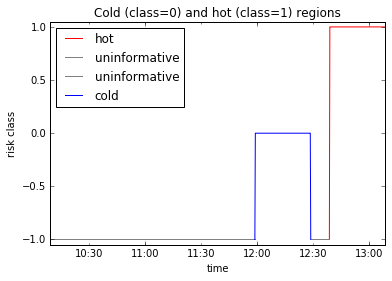

In [4]:
s = pnd.Series(X[X.group==79].risk[-3*60*4:])
s.index = X[X.group==79].time[-3*60*4:]
s[-30*4-1:].plot(color='red',label='hot')
s[-3*60*4:-70*4].plot(color='gray',label='uninformative')
s[-40*4:-30*4].plot(color='gray',label='uninformative')
s[-70*4-1:-40*4].plot(color='blue',label='cold')
#s.plot()
plt.ylim((-1.05,1.05))
plt.ylabel('risk class')
plt.title('Cold (class=0) and hot (class=1) regions')
plt.legend(loc="best")
plt.show()

In [5]:
# drop timestamp and risk features
group0 = X['group']
X = X.drop('group',axis=1)
y = X['risk']
X = X.drop('risk',axis=1)
time0 = X['time']
X = X.drop('time',axis=1)

## Model evaluation strategy

The data is correlated at the time-stamp level, however we can assume the *scenarios are iid*. Therefore, a **group-aware cross-validation** scheme is used, to estimate the generaliation error. This enforces all samples from a single scenario to be either in the training or in the test set.

For illustration purposes, we will also use a **leave-one-out** split, where the model will be trained on the data from all scenarios but one, and tested on this remaining scenario.

The results from the cross-validation should be compared against the maximal class probability, which is 0.5 in the considered case. Any non-trivial *advantage over 0.5* is a statistical evidence that 
cold and hot time regimes can be distinguished.

In [6]:
cv_gkf = GroupKFold(n_splits=3)

## Target constraints for training

During training, samples belonging to class -1 will not be considered.

In [7]:
#restrict the dataset to meaningfull targets 0 and 1, ignoring class -1

class TargetProjection():
    
    def __init__(self):
        return None
    
    def fit(self,X,y):
        return None
    
    def transform(self,X,y):
        return X[y>-1]
    
# end TargetProjection

## Feature ingeneering

Every scenario is a *multivariate time series*. To analyse such objects, one typically creates additional features such as *lagged* observations, *differences* between observations, or statistics over most recent observations - *rolling windows*. Often the time series needs to be smoothed, for example by *moving averages* to eliminate local noise.

This old-fashioned way of analysing time series is succesfull also on this data set (see the table below).

In [8]:
# generate features for the time series

# note: to optimize the performance, create stats over entire data frames not individual columns!

class FeatureExtractor():

    def __init__(self, deviations_span=-3*4, lags_span=5*4, differences_span=1,smooth_span=5*4):
        self.deviations_span = deviations_span
        self.lags_span = lags_span
        self.differences_span = differences_span
        self.smooth_span = smooth_span
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # copy the input table
        dt = X.copy()
        # add derivatives
        if self.differences_span > 0:
            tmp = dt.diff(periods=self.differences_span)
            tmp_names = {name: name+'_d' for name in dt.columns}
            tmp = tmp.rename(columns=tmp_names)
            dt = pnd.concat([dt,tmp],axis=1)
        # add lags 
        if self.lags_span > 0:
            tmp = dt.shift(periods=self.lags_span)
            tmp_names = {name: name+'_lag' for name in dt.columns}
            tmp = tmp.rename(columns=tmp_names)
            dt = pnd.concat([dt,tmp],axis=1)
        # add deviations (exponential moving weights)
        if self.deviations_span > 0:
            tmp = dt.rolling(window=self.deviations_span).std()
            tmp_names = {name: name+'_std' for name in dt.columns}
            tmp = tmp.rename(columns=tmp_names)
            dt = pnd.concat([dt,tmp],axis=1)
        # smooth by averages (exponential moving weights)
        if self.smooth_span > 0:
            dt = dt.ewm(span=self.smooth_span).mean()

        return dt.fillna(method='ffill',axis=1)
    # end FeatureExtractor

# extract features (the default setting)
X_f = FeatureExtractor().transform(X)
X_f.shape

(449358, 304)

To compare different ways of feature engineering, we train a (light) random forest model, and use its predictions to see which sets of features are better.

In [9]:
# build the grid of parameters 
extraction_param = []
extraction_param.append( {'deviations_span':0,'lags_span':0,'differences_span':0,'smooth_span':0} )
extraction_param.append( {'deviations_span':0,'lags_span':4*5,'differences_span':0,'smooth_span':0} )
extraction_param.append( {'deviations_span':0,'lags_span':4*5,'differences_span':1,'smooth_span':0} )
extraction_param.append( {'deviations_span':0,'lags_span':4*5,'differences_span':1,'smooth_span':4*5} )
    
descriptions = ['raw series','raw + lags','raw + lags + differences','raw + lags + differences + EMA']

#tmp = pnd.DataFrame(columns=['technique','accuracy','error'])

tmp = None
for i in range(len(descriptions)):
    # transform data and train the model
    X_train = FeatureExtractor(
                deviations_span = extraction_param[i]['deviations_span'], 
                differences_span = extraction_param[i]['differences_span'],
                lags_span = extraction_param[i]['lags_span'],
                smooth_span = extraction_param[i]['smooth_span']
              ).transform(X, y)
    X_train = TargetProjection().transform(X_train,y)
    y_train = TargetProjection().transform(y,y)
    group_train = TargetProjection().transform(group0,y)

    clf0 = ensemble.RandomForestClassifier(max_depth=5,n_estimators=50,random_state=13, n_jobs=-1)

    cv=list(cv_gkf.split(X_train,y_train,group_train))
    results = cross_val_score(clf0,X_train,y_train,cv=cv)
        
    # present the results in a table
    row = np.array([descriptions[i],X_train.shape[1], results.mean(),2*results.std()])
    if tmp is None :
        tmp = row
    else:
        tmp = np.column_stack([tmp,row])
        
tmp = pnd.DataFrame(data=tmp.T,columns=['technique','n_features','accuracy','error (=2xstd)'])
# show the table
tmp

,technique,n_features,accuracy,error (=2xstd)
0,raw series,76,0.543664842828,0.0291751067598
1,raw + lags,152,0.550906555091,0.00831576971358
2,raw + lags + differences,304,0.622733612273,0.10185555168
3,raw + lags + differences + EMA,304,0.629277974466,0.05828152764


We conclude that **lags, differences and moving averages** are good candidates for features.

Note: smoothing by moving averages reduces the variance a lot!

Note: generating features by *neural-networks* could be more successfull, but if more supervision information was given.

## Feature selection

To make the training more accurate, we need to narrow down the space of features. There are many ways of doing this,
below we use *recursive feature elimination* by random forests. In every step, the random forest model is created to  estimates feature importances, and worst features are eliminated.

On this data set, this approach was more effective that simpler *univariate* feature elimination techniques.

In [10]:
X_c = TargetProjection().transform(X_f,y)
y_c = TargetProjection().transform(y,y)
group = TargetProjection().transform(group0,y)

X_c.shape

(18642, 304)

In [11]:
# train the feature eliminator - this may take a while!
FeatureSelector = make_pipeline(
    preprocessing.MaxAbsScaler(), 
    #feature_selection.SelectFromModel(ensemble.RandomForestClassifier(random_state=13), threshold='mean'),
    RFE(ensemble.RandomForestClassifier(max_depth=5,n_estimators=30,random_state=13, n_jobs=-1), 
     n_features_to_select=30, step=2)
)

X_t = FeatureSelector.fit_transform(X_c,y_c)

In [12]:
best_features = X_c.columns[ FeatureSelector.steps[-1][1].get_support() ]
print('Top features = {0}'.format(','.join(best_features) ))

Top features = var26,var42,var46,var54,var70,var71,var72,var16_d,var42_d,var47_d,var54_d,var60_d,var70_d,var72_d,var73_d,var19_lag,var24_lag,var44_lag,var54_lag,var56_lag,var58_lag,var65_lag,var16_d_lag,var47_d_lag,var49_d_lag,var58_d_lag,var60_d_lag,var70_d_lag,var72_d_lag,var73_d_lag


In [13]:
# add indexes and column names to the transformed dataframe
X_t = pnd.DataFrame(X_t, index = X_c.index)
X_t = X_t.rename(columns= {k:v for k,v in zip( range(5),best_features) } )

X_t.shape

(18642, 30)

## Random Forest Model and Results (break point detection)

### Evaluation by cross-validation

In [14]:
X_train = X_t
y_train = y_c
group_train = group

clf = ensemble.RandomForestClassifier(criterion="entropy",max_depth=5,n_estimators=50,
                                      min_samples_leaf=10,random_state=13, n_jobs=-1)
#clf = linear_model.LogisticRegression()

clf.fit(X_train,y_train)
print('fitting: %s'%clf.score(X_train,y_train))

cv=list(cv_gkf.split(X_train,y_train,group_train))
results = cross_val_score(clf,X_train,y_train,cv=cv)

print("cross-validation: mean={0} +/- 2* {1}".format(results.mean(),results.std()))


fitting: 0.843310803562
cross-validation: mean=0.6488574187318957 +/- 2* 0.025127630634497338


#### Optimization

The bagging technique is used to further decrease the variance.

In [15]:
clfbag = ensemble.BaggingClassifier(clf, n_estimators=15, random_state=13)
results = cross_val_score(clfbag,X_train,y_train,cv=cv)
print("cross-validation (bagging): mean={0} +/- 2* {1}".format(results.mean(),results.std()))

cross-validation (bagging): mean=0.6352859135285914 +/- 2* 0.012789614423416685


In [16]:
# mode detailed optimization can be done by cross-validated grid search, 

# but it should also cover tunning parameters for generating features - too expensive.

from scipy.stats import randint as sp_randint

param_dist = {'n_estimators': [30,50,75],
              'max_depth': [3, 5],
              'min_samples_leaf': sp_randint(2,12),
              'min_samples_split': sp_randint(5,20),
              #'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']
}

random_search = RandomizedSearchCV(clf, param_distributions=param_dist,n_iter=20, cv=cv, n_jobs=-1)
random_search.fit(X_train,y_train)

print("Optimized score={0}\nBest parameters={1}".format(random_search.best_score_,random_search.best_params_))

Optimized score=0.6343203518935736
Best parameters={'min_samples_leaf': 10, 'criterion': 'entropy', 'min_samples_split': 13, 'n_estimators': 75, 'max_depth': 5}


The conclusion is that the time after the break point (last 0-30 minutes) and before (last 40-70 minutes) can be statistically distingushed!

### One-Group-Out Experiment

To illustrate the results, let's fix one group as a hold-out testing set, and train the model on the remaining data.

In [37]:
# do the split and train the model

def fit_all_but_one(clf, group_out=13):
    X_train = X_t[group!=group_out]
    y_train = y_c[group!=group_out]
    return clf.fit(X_train,y_train)

def testset_all_but_one(group_out=13):    
    # the data for testing is unrestricted - we take all time stamps! 
    X_test = FeatureSelector.transform(X_f[group0==group_out].fillna(method='ffill',axis=1))
    X_test = pnd.DataFrame(X_test)
    y_test = y_c[group==group_out]
    return X_test, y_test

group_out = 33

X_test, y_test = testset_all_but_one(group_out)
group_train = group[group!=group_out]
cv=list(cv_gkf.split(X_t[group!=group_out],y_c[group!=group_out],group_train))
clf = fit_all_but_one(clf,group_out)

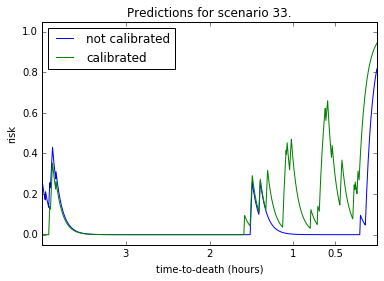

In [40]:
# plot the results 

# callibrate the classifier
clf_isotonic = CalibratedClassifierCV(clf, cv=cv, method='isotonic')
clf_isotonic = fit_all_but_one(clf_isotonic,group_out)

# note: the prediction curve is smoothed
pnd.Series(clf.predict(X_test)).ewm(span=10*4).mean()[-4*60*4:].plot(label='not calibrated')
pnd.Series(clf_isotonic.predict(X_test)).ewm(span=10*4).mean()[-4*60*4:].plot(label='calibrated')
# remember the time-stamp frequency is 15s!
x_offest = len(X_test)-np.array([4*30,4*60,2*4*60,3*4*60])
plt.xticks(x_offest,[0.5,1,2,3])
plt.ylim((-0.05,1.05))
plt.xlabel('time-to-death (hours)')
plt.ylabel('risk')
plt.title('Predictions for scenario {0}.'.format(group_out))
plt.legend(loc='upper left')
plt.show()

Note that the calibration 'pushed' predictions towards 1 for the last hour, improving the accuracy.

## Random Forest Model and Results (real time risk modelling)

Turning class predictions into confidence estimates (numbers between 0 and 1 indicating the risk) 
can be done in many ways. 

<ul>(a) The simplest way is to smooth predictions as illustrated above (naive)</ul>

<ul>(b) Regression of 0-1 predictions is yet another way (heuristic)</ul>

<ul>(c) Some models, like random forest or logistic regression, already calculate the probabilities internally (but may require callibration!)</ul>

Below we use the last approach and one-group-out train/test splits to illustrate the results for all scenarios. 

Note that these estimates are just to illustrate the technique, as more supervised data is needed - more scenarios and also more about the behavior trough the entire scenario path (we don't know if the machine was operating correctly or not)


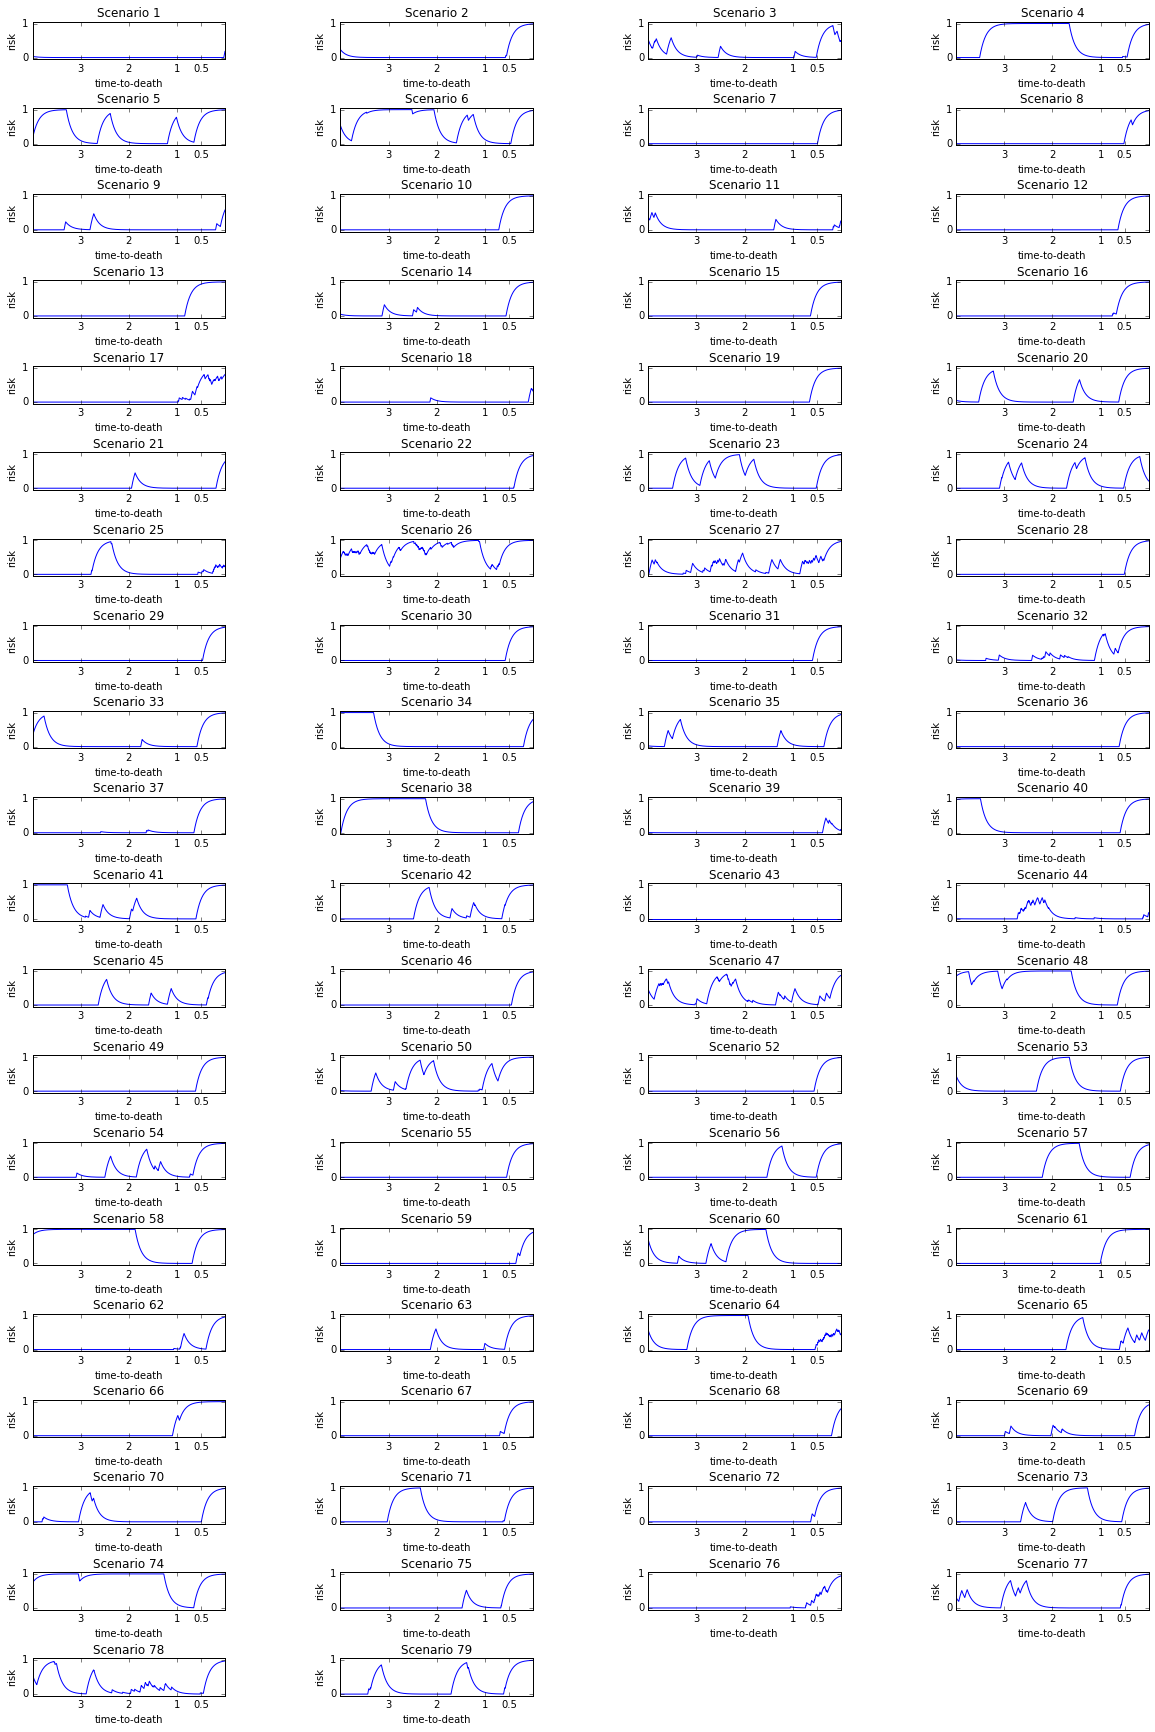

In [21]:
#rfr = ensemble.RandomForestRegressor(n_estimators=20,max_features=10,max_depth=5,min_samples_leaf=10, random_state=13, n_jobs=-1)

clf = ensemble.RandomForestClassifier(criterion="entropy",max_depth=5,n_estimators=30,
                                      min_samples_leaf=10,random_state=13, n_jobs=-1)

fig = plt.figure(figsize=(20,30))
fig.subplots_adjust(hspace=1.3,wspace=0.6)
group_list = group.unique()
for i in range(len(group_list)):
    ax = fig.add_subplot(20,4,i+1)
    # compute predictions for scenario i    
    clf0 = fit_all_but_one(clf,group_list[i])
    cv=list(cv_gkf.split(X_t[group!=group_list[i]],y_c[group!=group_list[i]],group[group!=group_list[i]]))
    # calibrate the classifier
    clf_isotonic = CalibratedClassifierCV(clf0, cv=cv, method='isotonic')
    clf_isotonic = fit_all_but_one(clf_isotonic,group_out)
    X_test, y_testrfr = testset_all_but_one(group_list[i])
    pnd.Series(clf_isotonic.predict(X_test)).ewm(span=15*4).mean()[-4*60*4:].plot()
    ax.set_ylabel('risk')
    ax.set_xlabel('time-to-death')
    x_offest = len(X_test)-np.array([4*30,4*60,2*4*60,3*4*60])
    plt.xticks(x_offest,[0.5,1,2,3])
    plt.ylim((-0.05,1.05))
    plt.yticks([0,1])
    ax.set_title('Scenario %s'%group_list[i])
plt.show()

## Literature

Random forest techniques for detecting change points in time series are studied in the classical paper *Change point detection in time series data with random forests* by Lidia Auret and Chris Aldrich.

A recent paper *Feature Selection for Change Detection in Multivariate Time-Series* by Michael Botsch and Josef
A. Nossek discusses how to build a model and select features for time series with known (supervised) break points. The author suggest to use random forests for feature selection, and also customize the scoring metric so that it penalizes less mistakes around change points (which intuitively makes sense as the change is typically continuous).